In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
from math import floor, ceil
import matplotlib.pyplot as plt

In [2]:
from rtseg.cellseg.dataloaders import PhaseContrast
from rtseg.cellseg.utils.transforms import transforms
import torchvision
from rtseg.cellseg.networks import model_dict

In [3]:
model = model_dict["ResUnet"]

In [4]:
model=model.parse(channels_by_scale=[1, 32, 64, 128, 256], num_outputs=[1, 2, 1],
                   upsample_type='transpose_conv', feature_fusion_type= 'concat', skip_channel_seg=True)

In [5]:
a, b = model(torch.ones(1, 1, 320, 320))
print(a.shape, b.shape)

torch.Size([1, 1, 320, 320]) torch.Size([1, 2, 320, 320])


In [6]:
DATA_DIR = Path('/home/pk/Documents/rtseg/data/cellseg/omnipose/')
phase_dir = DATA_DIR / Path('bacteria_test')
labels_dir = DATA_DIR / Path('test_masks')
vf_dir = DATA_DIR / Path('vf_test')

In [7]:
test_ds = PhaseContrast(phase_dir, labels_dir, vf_dir, vf = False, transforms=transforms['eval'])

In [8]:
len(test_ds)

98

In [9]:
phase, mask = test_ds[10]

In [10]:
phase.shape, mask.shape

((1, 592, 468), (1, 592, 468))

In [11]:
test_dl = DataLoader(test_ds, batch_size=1, pin_memory=False, shuffle=False, drop_last=False, num_workers=2)
test_dl_iter = iter(test_dl)

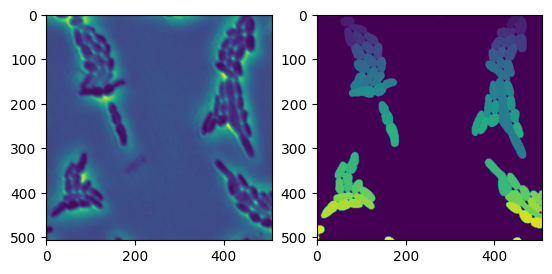

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2)
image, mask = next(test_dl_iter)
ax[0].imshow(image[0][0].numpy())
ax[1].imshow(mask[0][0].numpy())
plt.show()

In [13]:
def batch_of_n(arr, n):
    """ Given an array, split into batches of size n. """
    for i in range(0, len(arr), n): 
        yield arr[i : i + n]


### Tiling mode

In [14]:
class TilerBase(nn.Module):

    def __init__(self, model, tile_size=(320, 320), overlap=48, batch_size=2, device="cpu", strict=True):
        super(TilerBase, self).__init__()
        self.model = model
        self.TH, self.TW = tile_size
        self.overlap = overlap
        self.batch_size = batch_size
        self.device = device
        self.strict = strict

        self.stride_H = self.TH - self.overlap  # stride height
        self.stride_W = self.TW - self.overlap  # stride width

    def tile_transform(self, image, overflow):
        pass
        
    def tile_image(self, image):
        B, C, H, W = image.shape

        # strict enforcement as images in test sets are different shape
        # For inference at run time, we can use batching of tiles from a 
        # batch of images of the same shape.
        #if self.strict:
        #    assert B == 1, f"Batch size of 1 required in strict mode. Found batch size {B}."

        overflow = self._tiling_overflow(image.shape)
        # all subclasses of tiler should implement a tile_transfrom
        padded_image = self.tile_transform(image, overflow)

        B, C, NH, NW = padded_image.shape

        # Now if you check tiling overflow, it should return 0s
        H_check, W_check = self._tiling_overflow((B, C, NH, NW))

        assert not H_check, "Tiling failed in the height dimension"
        assert not W_check, "Tiling failed in the width dimension"

        # 1. Find the number of tiles in X and Y direction
        H_tiles = int(1 + (NH - self.TH) / (self.TH - self.overlap))
        W_tiles = int(1 + (NW - self.TW) / (self.TW - self.overlap))
        
        # 2. The actual indices of tiles: (n_tiles, 4)
        tiles = []
        for H_n in range(H_tiles):
            for W_n in range(W_tiles):
                left = int(H_n * (self.TH - self.overlap))
                right = int(W_n * (self.TW - self.overlap))

                # Going to be from (y_0, x_0, y_1, x_1)
                tiles.append([left, right, left + self.TH, right + self.TW])
        #print(f"Tiles: {tiles}")
        # 3.
        tiled_images = []
        for i in range(B):
            for y_0, x_0, y_1, x_1 in tiles:
                tiled_images.append(
                    padded_image[i][:, y_0:y_1, x_0:x_1]
                )
            
        tiled_images = torch.stack(tiled_images)
        
        return tiled_images, tiles, padded_image.shape

    def _tiling_overflow(self, image_size):
        #print(image_size)
        
        B, C, H, W = image_size

        H_overflow = self.TH + self.stride_H * ceil(max((H - self.TH), 0) / self.stride_H) - H
        W_overflow = self.TW + self.stride_W * ceil(max((W - self.TW), 0) / self.stride_W) - W

        #print(f"H_overflow: {H_overflow}, W_overflow: {W_overflow}")
        return H_overflow, W_overflow

    def merge_transform(self):
        pass
        
    def merge_tiles(self, tiled_images, tiles, new_shape, original_shape):
        B, _, H, W = original_shape
        #print(f"Original batch size: {B}")
        _, C, TH, TW = tiled_images.shape
        _, _, NH, NW = new_shape

        # Don't want to include borders when stitching back
        # together as they often generate artifacts
        extra = int(self.overlap // 4) # 25 % of the overlap

        average = torch.zeros((B, C, NH, NW), device=self.device)
        merged_pred = torch.zeros((B, C, NH, NW), device=self.device)
        
        n_tiles = len(tiles)
        for i, (y_0, x_0, y_1, x_1) in enumerate(tiles):
            tiled_image = tiled_images[i::n_tiles, ...]
            #print(f"Tiled image shape: {tiled_image.shape}, [y_0, x_0, y_1, x_1]: {y_0}, {x_0}, {y_1}, {x_1}")
            ty_0, tx_0, ty_1, tx_1 = 0, 0, self.TH, self.TW

            if y_0:
                y_0 = y_0 + extra
                ty_0 = extra
                
            if x_0:
                x_0 = x_0 + extra
                tx_0 = extra

            if y_1 != NH:
                y_1 = y_1 - extra
                ty_1 = self.TH - extra

            if x_1 != NW:
                x_1 = x_1 - extra
                tx_1 = self.TW - extra
            #print(f"[y_0, x_0, y_1, x_1]: {y_0}, {x_0}, {y_1}, {x_1}")
            #print(f"[ty_0, tx_0, ty_1, tx_1]: {ty_0}, {tx_0}, {ty_1}, {tx_1}")
            average[:, :, y_0:y_1, x_0:x_1] += 1
            merged_pred[:, :, y_0:y_1, x_0:x_1] += tiled_image[:, :, ty_0: ty_1, tx_0: tx_1]

        merged_pred = merged_pred / average

        # For paddig and reshape this will reshape final predictions
        pred = self.merge_transform(merged_pred, new_shape, original_shape)

        return pred
    
    def forward(self, image):
        tiled_images, tiles, new_shape = self.tile_image(image)
        #return None
        batches = batch_of_n(tiled_images, self.batch_size)
        
        # Predict VF and semantic on each tiling batch
        vf_batched = []
        semantic_batched = []
        for batch in batches:
            semantic, vf = self.model(batch)
            
            semantic_batched.append(semantic)
            vf_batched.append(vf)

        vf_batched = torch.vstack(vf_batched)
        semantic_batched = torch.vstack(semantic_batched)

        #print(f"Vf_batched: {vf_batched.shape}")
        #print(f"Semantic batched: {semantic_batched.shape}")
        #print(f"Tiles in forward just before merging: {tiles}")
        # Stitching of predicted tiles
        vf = self.merge_tiles(vf_batched, tiles, new_shape, image.shape)
        semantic = self.merge_tiles(semantic_batched, tiles, new_shape, image.shape)

        #print("After merging")
        #print(f"vf shape: {vf.shape}")
        #print(f"semantic shape: {semantic.shape}")
        #return None
        return semantic, vf

In [15]:
class PaddingTiler(TilerBase):
    def tile_transform(self, image, overflow):
        H_overflow, W_overflow = overflow

        H_pad, W_pad = int(H_overflow // 2), int(W_overflow // 2)
        H_extra, W_extra = int(H_overflow % 2), int(W_overflow % 2)

        padding = (W_pad, W_pad + W_extra, H_pad, H_pad + H_extra)

        try:
            padded_image = F.pad(image, padding, mode = "reflect")
        except:
            padded_image = F.pad(image, padding, mode = "replicate")

        return padded_image

    def merge_transform(self, merged_pred, new_shape, original_shape):
        _, _, H, W = original_shape
        _, _, NH, NW = new_shape

        H_total_pad, W_total_pad = NH - H, NW - W
        H_pad, W_pad             = H_total_pad // 2, W_total_pad // 2
        H_pad_extra, W_pad_extra = H_total_pad % 2, W_total_pad % 2

        H_last = NH - (H_pad + H_pad_extra)
        W_last = NW - (W_pad + W_pad_extra)
        
        pred = merged_pred[:, :, H_pad : H_last, W_pad : W_last]

        return pred

In [16]:
class ResizeTiler(TilerBase):
    def tile_transform(self, image, overflow):
        B, C, H, W = image.shape
        H_overflow, W_overflow = overflow

        H_resize = H + H_overflow
        W_resize = W + W_overflow

        resized_image = torchvision.transforms.Resize((H_resize, W_resize), antialias=True)(image)

        return resized_image
        
    def merge_transform(self, merged_pred, new_shape, original_shape):
        _, _, H, W = original_shape

        pred = torchvision.transforms.Resize((H, W), antialias=True)(merged_pred)

        return pred

In [36]:
class DynamicOverlapTiler(TilerBase):
    def tile_transform(self):
        H_overflow, W_overflow = overflow

        H_pad, W_pad     = int(H_overflow // 2), int(W_overflow // 2)
        H_extra, W_extra = int(H_overflow  % 2), int(W_overflow  % 2)

        padding = (W_pad, W_pad + W_extra, H_pad, H_pad + H_extra)
        padded_image = F.pad(image, padding, mode = "constant", value = 0)

        return padded_image 


    def merge_transform(self, merged_pred, new_shape, original_shape):
        _, _,  H,  W = original_shape
        _, _, NH, NW = new_shape

        H_total_pad, W_total_pad = NH - H, NW - W
        H_pad, W_pad             = H_total_pad // 2, W_total_pad // 2
        H_pad_extra, W_pad_extra = H_total_pad % 2, W_total_pad % 2

        H_last = NH - (H_pad + H_pad_extra)
        W_last = NW - (W_pad + W_pad_extra)
        
        pred = merged_pred[:, :, H_pad : H_last, W_pad : W_last]

        return pred


    def tile_image(self, image):
        B, C, H, W = image.shape

        # assert B == 1, f"Batch size of 1 required. Found batch size {B}."

        if H < self.TH:
            image = self.tile_transform(image, (self.TH - H, 0))

        if W < self.TW:
            image = self.tile_transform(image, (0, self.TW - W))

        B, C, H, W = image.shape

        # Now find the indexes, should be shape: (tiles, 4)
        # 1. Find the number of tiles in X and Y direction.
        H_tiles = int(1 + (H - self.TH) / (self.TH - self.overlap)) + 1
        W_tiles = int(1 + (W - self.TW) / (self.TW - self.overlap)) + 1 

        # 2. Find the actual indides of shape: (tiles, 4) 
        # This is done from left to right, top to bottom.
        tiles = []
        for H_n in range(H_tiles):
            for W_n in range(W_tiles):
                left  = int(H_n * (self.TH - self.overlap))
                right = int(W_n * (self.TW - self.overlap))

                if left + self.TH > H: 
#                    print(left)
                    left = H - self.TH 
#                    print(left)

                if right + self.TW > W:
                    right = W - self.TW 

                # Going to be in form (y_0, x_0, y_1, x_1)
                tiles.append([left, right, left + self.TH, right + self.TW])

        # 3. Create the tiled images from the tiles computed
        # in step 2.
        tiled_images = []
        for i in range(B):
            for y_0, x_0, y_1, x_1 in tiles:
                tiled_images.append(
                    image[i][:, y_0 : y_1, x_0 : x_1]
                )
            
        tiled_images = torch.stack(tiled_images)

        return tiled_images, tiles, image.shape


In [37]:
resizer = ResizeTiler(model= model.to('cuda:0'), device='cuda:0')
padder = PaddingTiler(model=model.to('cuda:0'), device='cuda:0')
dynamic = DynamicOverlapTiler(model= model.to("cuda:0"), device="cuda:0")

In [38]:
resizer.TH, resizer.TW

(320, 320)

In [39]:
images = torch.ones((4, 1, 520, 512), device='cuda:0')

In [40]:
semantic, vf = padder(images)
print(f"Semantic shape: {semantic.shape}, vf shape: {vf.shape}, images shape: {images.shape}")

Semantic shape: torch.Size([4, 1, 520, 512]), vf shape: torch.Size([4, 2, 520, 512]), images shape: torch.Size([4, 1, 520, 512])


In [41]:
semantic, vf = resizer(images)
print(f"Semantic shape: {semantic.shape}, vf shape: {vf.shape}, images shape: {images.shape}")

Semantic shape: torch.Size([4, 1, 520, 512]), vf shape: torch.Size([4, 2, 520, 512]), images shape: torch.Size([4, 1, 520, 512])


In [44]:
semantic, vf = dynamic(images)
print(f"Semantic shape: {semantic.shape}, vf shape: {vf.shape}, images shape: {images.shape}")

Semantic shape: torch.Size([4, 1, 520, 512]), vf shape: torch.Size([4, 2, 520, 512]), images shape: torch.Size([4, 1, 520, 512])


In [137]:
resizer(images)

Tiles: [[0, 0, 320, 320], [0, 272, 320, 592], [272, 0, 592, 320], [272, 272, 592, 592]]
Vf_batched: torch.Size([4, 2, 320, 320])
Semantic batched: torch.Size([4, 1, 320, 320])


RuntimeError: The size of tensor a (308) must match the size of tensor b (320) at non-singleton dimension 3

In [54]:
tiles

[[0, 0, 320, 320],
 [0, 272, 320, 592],
 [272, 0, 592, 320],
 [272, 272, 592, 592]]

In [55]:
tiled_images, tiles, padded_image_shape = padder.tile_image(images)

Tiles: [[0, 0, 320, 320], [0, 272, 320, 592], [272, 0, 592, 320], [272, 272, 592, 592]]


In [56]:
tiled_images.shape

torch.Size([8, 1, 320, 320])

In [57]:
tiles

[[0, 0, 320, 320],
 [0, 272, 320, 592],
 [272, 0, 592, 320],
 [272, 272, 592, 592]]

In [58]:
padded_image_shape

torch.Size([2, 1, 592, 592])